In [1]:
# Import Libraries
import sys, os

import numpy as np
import pandas as pd
import scipy
import pickle

from IPython.display import clear_output
from matplotlib import pyplot as plt

import torch
from torch import nn
from torchvision import datasets, transforms

source = "../source"
sys.path.append(source)

from preprocessing import Direct
from compilation import Compiler
from activations import get_activations
import publication
import models

device = torch.device("cpu")

In [2]:
## Load the data
encoding = Direct()
input_size = 28 * 28
output_size = 10

input_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Lambda(torch.ravel),
        transforms.Lambda(lambda x: x.to(device)),
    ]
)
output_transforms = transforms.Lambda(
    lambda y: torch.zeros(10, dtype=torch.float)
    .scatter_(0, torch.tensor(y), value=1)
    .to(device)
)

train_data = datasets.MNIST(
    "./data/MNIST",
    train=True,
    download=True,
    transform=input_transforms,
    target_transform=output_transforms,
)
val_data = datasets.MNIST(
    "./data/MNIST",
    train=False,
    download=True,
    transform=input_transforms,
    target_transform=output_transforms,
)

train_datasets = [torch.utils.data.Subset(train_data, np.arange(60000))]
tracked_datasets = [val_data] + train_datasets

analyzed_data = torch.utils.data.Subset(train_data, np.arange(100))
labels = np.array([np.argmax(y.cpu()) for x, y in analyzed_data])
analyzed_data = torch.utils.data.Subset(train_data, np.argsort(labels))
labels = labels[np.argsort(labels)]

In [3]:
## Theory prediction
N = 10000

X = train_data.train_data[:N]
X = X.reshape(X.shape[0], -1).numpy()
D_x = scipy.spatial.distance.cdist(X, X)

Y = torch.nn.functional.one_hot(train_data.train_labels[:N])
D_y = scipy.spatial.distance.cdist(Y, Y)

A_low = D_x * D_y

pred = np.exp(-A_low) @ A_low @ np.exp(-A_low)
labels = train_data.train_labels[:100]
pred = pred[np.argsort(labels)].T[np.argsort(labels)]

labeling = [None] * len(labels)
count = 0
for digit in range(10):
    n_digit = np.sum(np.sort(labels) == digit)
    labeling[count + int(n_digit / 2)] = digit
    count += n_digit

publication.set_color_gradient(2)
fig = plt.figure(figsize=(3, 3))
plt.imshow(pred**2)
publication.im_show(
    colorbar=False,
    x_labels=labeling,
    y_labels=labeling,
    save_path="plots/mnist/structure/theory",
)

/home/loek/miniconda3/envs/rnn/lib/python3.10/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [ ]:
## Load settings
settings = "low_init"

(
    model_type,
    nonlinearity,
    gain,
    lr,
    P,
    L,
    n_epochs,
    hidden_layer,
    dx2,
    dy2,
    in_dim,
    out_dim,
) = (
    pd.read_csv("model_settings/mnist.txt", sep=" ", header=0).loc[settings].to_numpy()
)
model_type = getattr(models, model_type)
nonlinearity = getattr(torch.nn.functional, nonlinearity)

In [ ]:
def single_trial():
    ## Instantiate model
    model = model_type(
        encoding=encoding,
        input_size=input_size,
        output_size=output_size,
        hidden_dim=P,
        n_hid_layers=L,
        device=device,
        init_std=gain,
    )

    ## Setup compiler
    criterion = lambda x, y: 0.5 * nn.functional.mse_loss(x, y)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    compiler = Compiler(model, criterion, optimizer)
    compiler.trackers = {}

    ## Training run
    compiler.training_run(train_datasets, n_epochs=n_epochs, batch_size=64)

    ## Collect activations
    hid_act = get_activations(
        [analyzed_data], lambda x: model(x)[1][int(L / 2)], encoding
    )
    h = hid_act.to_numpy()
    dist2_h = np.array([[np.linalg.norm(h_1 - h_2) ** 2 for h_1 in h] for h_2 in h])

    return dist2_h

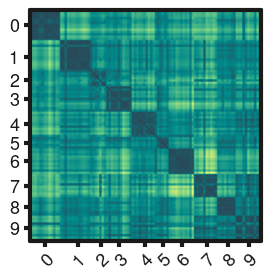

Training:  38%|███▊      | 19/50 [03:50<06:16, 12.15s/steps, train_loss=0.01351, val_loss=nan]


KeyboardInterrupt: 

In [ ]:
data_path = f"plots/mnist/structure/data.pkl"
if os.path.exists(data_path):
    with open(data_path, "rb") as f:
        data = pickle.load(f)
else:
    data = []

publication.set_color_gradients(2)
for _ in range(10):
    dist2_h = single_trial()
    data.append(dist2_h)
    with open(data_path, "wb") as f:
        pickle.dump(data, f)

    dist2_h_av = sum(data) / len(data)
    clear_output(wait=True)
    fig = plt.figure(figsize=(3, 3))
    plt.imshow(dist2_h_av)
    publication.im_show(
        colorbar=False,
        x_labels=labeling,
        y_labels=labeling,
        save_path="plots/mnist/structure/experiment",
    )

In [ ]:
x = np.ravel(pred)
y = np.ravel(dist2_h_av)
print(f"Pearson correlation coefficient: {scipy.stats.pearsonr(x,y)}")

In [ ]:
blocks = np.array([[i == j for i in np.sort(labels)] for j in np.sort(labels)])
x = np.ravel(pred)[~np.ravel(blocks)]
y = np.ravel(dist2_h_av)[~np.ravel(blocks)]
print(f"Pearson correlation coefficient without diagonal: {scipy.stats.pearsonr(x,y)}")